In [1]:
import numpy          as np
import pandas         as pd

import datetime
import time
import sys
import re

import smart_open
print(smart_open.__version__)

from gensim.parsing.preprocessing import remove_stopwords, split_alphanum, strip_punctuation, strip_short, strip_multiple_whitespaces, strip_non_alphanum, strip_numeric
from sklearn.feature_extraction.text import TfidfVectorizer

2.0.0


In [2]:
#data loading
df = pd.read_csv('~/Documents/air-qual-sample.csv')
# df = df.sample(random_state=100)
df['text'] = df['text'].fillna('').apply(str)
df.head(50)

,published_at,platform,text,username,link,published_at_day,published_at_time,total,replies,favorites,retweets,quotes
0,2020-05-28T17:18:57Z,twitter,RT @ToLey88 Sorry but it’s illegal to use the ...,adrien4ej,http://twitter.com/adrien4ej/statuses/12660563...,2020-05-28T17:18:57Z,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-05-28T17:18:14Z,twitter,RT @ninarobertsnyc I loved what @rontkim had t...,rontkim,http://twitter.com/rontkim/statuses/1266056199...,2020-05-28T17:18:14Z,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-05-28T17:17:44Z,twitter,"@maggiekb1 Look, all I want to do is start an ...",maggiekb1,http://twitter.com/maggiekb1/statuses/12660560...,2020-05-28T17:17:44Z,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-05-28T17:17:38Z,twitter,RT @HenryKraemer If you’re bothered by riots a...,mateosfo,http://twitter.com/mateosfo/statuses/126605604...,2020-05-28T17:17:38Z,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-05-28T17:16:48Z,twitter,RT @Exelon This is an opportunity to rebuild N...,CarbonFreeNY,http://twitter.com/CarbonFreeNY/statuses/12660...,2020-05-28T17:16:48Z,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-05-28T17:16:47Z,twitter,I am really having a hard time this morning wi...,maggiekb1,http://twitter.com/maggiekb1/statuses/12660558...,2020-05-28T17:16:47Z,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-05-28T17:16:04Z,twitter,@parkerpomeroy Inextricably,ialhusseini,http://twitter.com/ialhusseini/statuses/126605...,2020-05-28T17:16:04Z,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-05-28T17:15:53Z,twitter,RT @CMCarlinaRivera NY's voter registration de...,CarlinaRivera,http://twitter.com/CarlinaRivera/statuses/1266...,2020-05-28T17:15:53Z,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-05-28T17:15:27Z,twitter,RT @FiveThirtyEight Why is a respiratory disea...,maggiekb1,http://twitter.com/maggiekb1/statuses/12660554...,2020-05-28T17:15:27Z,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-05-28T17:15:22Z,twitter,Lack of healthy food options and quality sport...,ydanis,http://twitter.com/ydanis/statuses/12660554779...,2020-05-28T17:15:22Z,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#preprocessing
def clean(text):
    text = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', text, flags=re.MULTILINE) # urls
    text = re.sub(r'[\s]{0,1}([@#][\w_-]+)', '', text, flags=re.MULTILINE) # @mentions and #hashtags
    text = text.lower() # lowercase all text to use an uncased bert model
    text = text.strip(',.-_ ')
    text = split_alphanum(text.lower())
    text = remove_stopwords(text.lower())
    text = strip_non_alphanum(text.lower())
    text = strip_short(text.lower())
    text = strip_multiple_whitespaces(text.lower())
    text = re.sub('[\d]+', '', text, flags=re.MULTILINE)
    return text

''' 
def clean(text):
    text = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', document, flags=re.MULTILINE)
    text = split_alphanum(text.lower())
    text = remove_stopwords(text.lower())
    text = strip_non_alphanum(text.lower())
    text = strip_short(text.lower())
    text = strip_multiple_whitespaces(text.lower())
    return text
'''

# Change name of text column

df['clean_text'] = df['text'].apply(clean)

# remove empty text data due to the previous cleaning step
df['clean_text'] = df['clean_text'].replace('', np.nan)
df['clean_text'] = df['clean_text'].replace('nan', np.nan)
df = df.dropna(subset=['clean_text'])
df.tail(10)

,published_at,platform,text,username,link,published_at_day,published_at_time,total,replies,favorites,retweets,quotes,clean_text
5003,2020-05-26T17:42:56Z,twitter,@IamQuidpro Unbelievable! Yet it happened! #sh...,NJdoc,http://twitter.com/NJdoc/statuses/126533763873...,2020-05-26T17:42:56Z,NaN,NaN,NaN,NaN,NaN,NaN,unbelievable happened
5004,2020-05-26T17:42:55Z,twitter,"RT @Energy_Vision Bob Powell, founder and CEO ...",EMPIRECLEAN,http://twitter.com/EMPIRECLEAN/statuses/126533...,2020-05-26T17:42:55Z,NaN,NaN,NaN,NaN,NaN,NaN,bob powell founder ceo brightmark talks compan...
5005,2020-05-26T17:42:39Z,twitter,@NYGovCuomo announced that NYS's death toll ha...,CarlinaRivera,http://twitter.com/CarlinaRivera/statuses/1265...,2020-05-26T17:42:39Z,NaN,NaN,NaN,NaN,NaN,NaN,announced nys death toll fallen day row feels...
5006,2020-05-26T17:42:35Z,twitter,RT @IamQuidpro Minneapolis Police officer suff...,NJdoc,http://twitter.com/NJdoc/statuses/126533755032...,2020-05-26T17:42:35Z,NaN,NaN,NaN,NaN,NaN,NaN,minneapolis police officer suffocates kills ma...
5007,2020-05-26T17:42:11Z,twitter,RT @johnpavlovitz .@jack and @Twitter are fail...,NJdoc,http://twitter.com/NJdoc/statuses/126533744807...,2020-05-26T17:42:11Z,NaN,NaN,NaN,NaN,NaN,NaN,failing protect millions people enforcing comm...
5008,2020-05-26T17:42:07Z,twitter,RT @JuddLegum He also just tweeted -- and dele...,NJdoc,http://twitter.com/NJdoc/statuses/126533743156...,2020-05-26T17:42:07Z,NaN,NaN,NaN,NaN,NaN,NaN,tweeted deleted disgusting conspiracy theory j...
5009,2020-05-26T17:42:02Z,twitter,RT @davidmweissman @meghanailaB @JoeNBC @Twitt...,NJdoc,http://twitter.com/NJdoc/statuses/126533741371...,2020-05-26T17:42:02Z,NaN,NaN,NaN,NaN,NaN,NaN,tweets trump person this held accountable trum...
5010,2020-05-26T17:41:58Z,twitter,RT @WalshFreedom Every single Republican shoul...,NJdoc,http://twitter.com/NJdoc/statuses/126533739508...,2020-05-26T17:41:58Z,NaN,NaN,NaN,NaN,NaN,NaN,single republican asked agree trump mail votin...
5011,2020-05-26T17:41:50Z,twitter,RT @vladduthiersCBS Right on @tonydokoupil. Th...,WeatherProf,http://twitter.com/WeatherProf/statuses/126533...,2020-05-26T17:41:50Z,NaN,NaN,NaN,NaN,NaN,NaN,right that love great journalist phenomenal hu...
5012,2020-05-26T17:41:22Z,twitter,RT @kurteichenwald Ummm...wow. @GovKemp really...,NJdoc,http://twitter.com/NJdoc/statuses/126533724325...,2020-05-26T17:41:22Z,NaN,NaN,NaN,NaN,NaN,NaN,ummm wow thinks win reelection pile dead bodies


In [4]:
text = df['clean_text']
vectorizer = TfidfVectorizer(stop_words='english')
vectors = vectorizer.fit_transform(text)
words = vectorizer.get_feature_names()
print(words)
# dense = vectors.todense()
# denselist = dense.tolist()
# dense[0:100]

['aapi', 'abandoned', 'abb', 'abba', 'abc', 'abdication', 'abducted', 'abhor', 'abide', 'abilities', 'ability', 'abject', 'ablaze', 'able', 'aboard', 'abolish', 'abolition', 'aboriginal', 'abort', 'aborted', 'abortion', 'abramson', 'abrasive', 'abridging', 'abroad', 'absence', 'absent', 'absentee', 'absolute', 'absolutely', 'absolutists', 'absorb', 'absorbed', 'absorbing', 'absurd', 'abt', 'abuse', 'abused', 'abusers', 'abuses', 'abusing', 'abusive', 'academia', 'academic', 'academy', 'accdg', 'accelerate', 'accelerated', 'acceleration', 'accelerator', 'accelerators', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessed', 'accessing', 'accident', 'accidental', 'accidents', 'accommodate', 'accommodating', 'accompanied', 'accompanying', 'accomplices', 'accomplish', 'accomplished', 'accomplishments', 'according', 'account', 'accountability', 'accountable', 'accounted', 'accounts', 'accumulation', 'accuracy', 'accurate', 'accusation', 'accusations', 'accuse', 

In [5]:
print(vectors)
# print().sample
# vec = pd.DataFrame(densitylist, columns=words)



  (0, 10750)	0.3706159586089289
  (0, 11205)	0.2964232721009357
  (0, 6140)	0.39595576248829784
  (0, 11399)	0.3934045655679651
  (0, 10899)	0.3154704767305186
  (0, 5054)	0.47295937786925424
  (0, 9564)	0.3741881106086855
  (1, 6077)	0.14738161155791074
  (1, 11146)	0.14824739643949275
  (1, 1746)	0.14599120022931764
  (1, 1357)	0.19164679888773659
  (1, 10093)	0.2685418916774644
  (1, 2233)	0.21155540486653365
  (1, 1731)	0.2685418916774644
  (1, 1343)	0.1724279085428929
  (1, 6649)	0.17054412941205627
  (1, 6096)	0.16350799856390633
  (1, 9018)	0.6346662145996009
  (1, 872)	0.21155540486653365
  (1, 1344)	0.1737518004523081
  (1, 9472)	0.3352848759972401
  (1, 6165)	0.18319437934725782
  (2, 4680)	0.6576865481528655
  (2, 9722)	0.471358582725486
  (2, 6125)	0.4358944646490775
  :	:
  (4979, 6238)	0.2193588011694128
  (4979, 4179)	0.27588553728726456
  (4979, 574)	0.4533484270237916
  (4979, 9927)	0.29628622525360127
  (4979, 8174)	0.2240691904621071
  (4979, 10598)	0.137114374426641

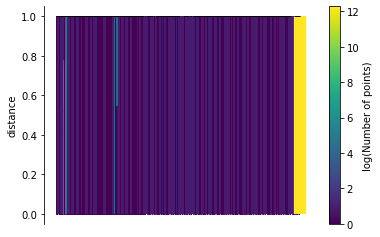

In [6]:
import hdbscan

clusterer = hdbscan.RobustSingleLinkage(cut=0.5, k=10, gamma=200)

cluster_labels = clusterer.fit_predict(vectors)
hierarchy = clusterer.cluster_hierarchy_
alt_labels = hierarchy.get_clusters(0.500, 5)
hierarchy.plot()

In [55]:


a = np.array(clusterer.labels_)
unique, counts = np.unique(a, return_counts=True)
x = dict(zip(unique, counts))

{k: v for k, v in sorted(x.items(), key=lambda item: item[1])}



{32: 10,
 6: 11,
 10: 11,
 13: 11,
 34: 11,
 15: 13,
 25: 15,
 40: 17,
 19: 18,
 24: 18,
 36: 19,
 18: 21,
 22: 22,
 1: 23,
 37: 23,
 33: 25,
 17: 26,
 26: 27,
 31: 30,
 35: 31,
 7: 34,
 11: 34,
 14: 34,
 28: 37,
 5: 40,
 3: 43,
 16: 44,
 27: 56,
 41: 56,
 21: 66,
 23: 67,
 29: 79,
 4: 89,
 8: 89,
 30: 91,
 39: 118,
 12: 128,
 0: 134,
 20: 187,
 -1: 233,
 9: 417,
 38: 525,
 2: 1999}

In [63]:
#  9: 417,
#  38: 525,
#  2: 1999

#     ONLY INTERESTED IN THESE LABELS

labels = np.array(clusterer.labels_)
np.where(labels == 2)
np.

# np.index(labels, value=2)

(array([ 390,  391,  392, ..., 2386, 2387, 2388]),)

In [52]:
hierarchy.to_numpy()

array([[3.156e+03, 3.168e+03, 0.000e+00, 2.000e+00],
       [2.979e+03, 2.984e+03, 0.000e+00, 2.000e+00],
       [2.978e+03, 4.983e+03, 0.000e+00, 3.000e+00],
       ...,
       [9.959e+03, 9.941e+03, 1.000e+00, 1.340e+02],
       [9.918e+03, 9.960e+03, 1.000e+00, 4.981e+03],
       [9.961e+03, 2.636e+03, 1.000e+00, 4.982e+03]])

In [9]:
hierarchy.to_pandas()

,parent,left_child,right_child,distance,size
0,4982,3156.0,3168.0,0.0,2.0
1,4983,2979.0,2984.0,0.0,2.0
2,4984,2978.0,4983.0,0.0,3.0
3,4985,2974.0,4984.0,0.0,4.0
4,4986,2947.0,4985.0,0.0,5.0
...,...,...,...,...,...
4976,9958,9957.0,1691.0,1.0,19.0
4977,9959,9958.0,1711.0,1.0,20.0
4978,9960,9959.0,9941.0,1.0,134.0
4979,9961,9918.0,9960.0,1.0,4981.0


In [10]:
hierarchy.get_clusters(cut_distance=0, min_cluster_size=50)

array([-1, -1, -1, ..., -1, -1, -1])

In [11]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
tree = clusterer.fit(vectors)

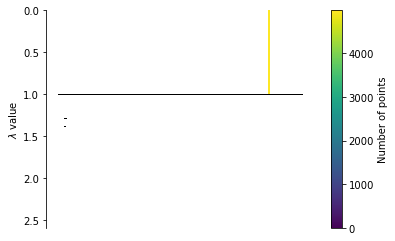

In [12]:
tree.condensed_tree_.plot()

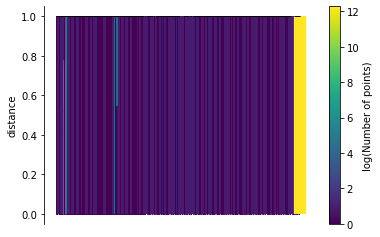

In [13]:
tree.single_linkage_tree_.plot()

In [14]:
tree.single_linkage_tree_.get_clusters(cut_distance=1)

array([-1, -1,  0, ..., -1, -1,  0])

In [15]:
tree.condensed_tree_.to_networkx()

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

# def plot_clusters(data, algorithm, args, kwds):
#     start_time = time.time()
#     labels = algorithm(*args, **kwds).fit_predict(data)
#     end_time = time.time()
#     palette = sns.color_palette('deep', np.unique(labels).max() + 1)
#     colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
#     plt.scatter(data.reshape(data.shape[0]), data.reshape(data.shape[1]), c=colors, **plot_kwds)
#     frame = plt.gca()
#     frame.axes.get_xaxis().set_visible(False)
#     frame.axes.get_yaxis().set_visible(False)
#     plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
#     plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    

# plot_clusters(vectors, hdbscan.HDBSCAN, (), {'min_cluster_size':15})
# input = np.array(vectors, dtype=float)

x = np.array(vectors.T[0], dtype=float)
y = np.array(vectors.T[1], dtype=float)

plt.scatter(x, y, c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

ValueError: setting an array element with a sequence.

AttributeError: 'numpy.ndarray' object has no attribute 'single_linkage_tree_'